In [1]:
import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sn = 1
setnumber = 'FD00' + str(sn)

In [3]:
# read data
print 'read data'
train = pd.read_csv('data/train_'+setnumber+'.csv')
train_RULs = np.array([train.loc[train.id==i, 'cycle'].max() for i in train.id.unique()])
test = pd.read_csv('data/test_'+setnumber+'.csv')
test_RULs = np.array([test.loc[test.id==i, 'RUL'].min() for i in train.id.unique()])
# drop the extra column
print 'drop index column'
train.drop('Unnamed: 0', 1, inplace=True)
test.drop('Unnamed: 0', 1, inplace=True)


read data
drop index column


In [4]:
print 'bin RUL values'
bins = [0, 30, 90, 180, 1000]
status_labels = ['urgent', 'short', 'medium', 'long']
train['status'] = pd.cut(train['RUL'], bins, labels=status_labels)
test['status'] = pd.cut(test['RUL'], bins, labels=status_labels)
print test.status.value_counts()

print 'normalize features (using MinMaxScaler)'
train_scalables = train.loc[:,train.columns.difference(['id', 'cycle', 'status'])].values
test_scalables = test.loc[:,test.columns.difference(['id', 'cycle', 'status'])].values

train_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(train_scalables)
test_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1)).fit(test_scalables)

train_values = train_scaler.transform(train_scalables)
test_values = test_scaler.transform(test_scalables)

train.loc[:,train.columns.difference(['id', 'cycle', 'status'])] = train_values
test.loc[:,test.columns.difference(['id', 'cycle', 'status'])] = test_values

bin RUL values
long      12498
medium      598
short         0
urgent        0
Name: status, dtype: int64
normalize features (using MinMaxScaler)


In [5]:
print train.columns
train_X = train.values[:,1:-2]
train_y = train.values[:,-2]
test_X = test.values[:,1:-2]
test_y = test.values[:,-2]


Index([u'id', u'cycle', u'setting1', u'setting2', u'setting3', u's1', u's2',
       u's3', u's4', u's5', u's6', u's7', u's8', u's9', u's10', u's11', u's12',
       u's13', u's14', u's15', u's16', u's17', u's18', u's19', u's20', u's21',
       u'RUL', u'status'],
      dtype='object')


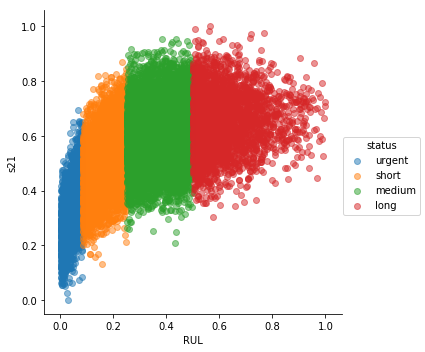

In [6]:
sns.lmplot('RUL', 's21', hue='status', data=train, fit_reg=False, scatter_kws={"alpha": 0.5})
plt.show()

In [7]:
nc=10
pca = sklearn.decomposition.PCA(n_components=nc)
pca.fit(train_X)
X = pca.transform(train_X)
evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()
print evals, evals_cs

[  9.99943722e-01   2.06480610e-05   1.25686755e-05   4.05365751e-06
   3.82350658e-06   3.33103431e-06   1.69439007e-06   1.53999529e-06
   1.40020800e-06   1.31210318e-06] [ 0.99994372  0.99996437  0.99997694  0.99998099  0.99998482  0.99998815
  0.99998984  0.99999138  0.99999278  0.99999409]


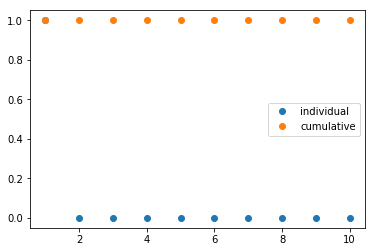

In [8]:
plt.plot(range(1, nc+1), evals, 'o', label='individual')
plt.plot(range(1, nc+1), evals_cs, 'o', label='cumulative')
plt.legend()
plt.show()

Index([u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9', u'status'], dtype='object')


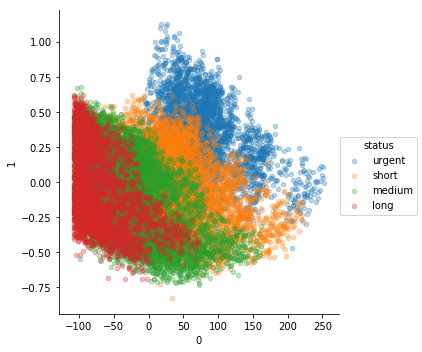

In [9]:
X = pd.DataFrame(X)
new_cols = [str(x) for x in X.columns]
X.columns = new_cols
X['status'] = train['status']
print X.columns
sns.lmplot('0', '1', hue='status', fit_reg=False, data=X, scatter_kws={'alpha':0.3, 's':20})
plt.show()

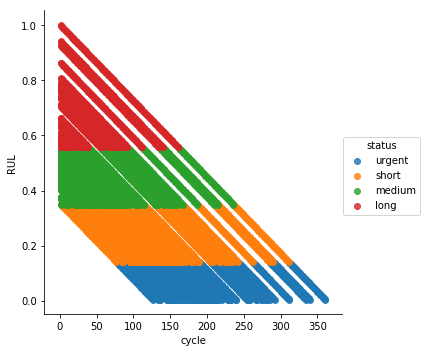

In [62]:
sns.lmplot('cycle', 'RUL', hue='status',fit_reg=False,  data=train)
plt.show()